# Categorical Model Dedicated Notebook

## Data Admin:

15795
15795
15795
15795
(15795, 120, 160, 3)


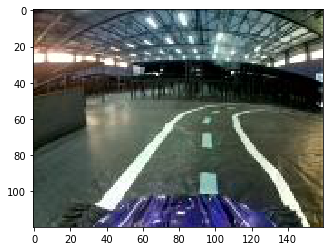

[0 0 1]


In [1]:
import os
import natsort
import numpy as np
import cv2
import json

import matplotlib.pyplot as plt

%matplotlib inline

#finding and sorting images and label data: - Unthresholded Images!
path = 'halldatarecords2/'

im_list = []

rec_list = []

for file in os.listdir(path):
    if 'cam' in file:
        im_list.append(file)
    elif 'record' in file:
        rec_list.append(file)

        
print(len(im_list))
print(len(rec_list))

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#reading in array of images:
x_images = np.zeros((len(rec_list), 120, 160, 3), dtype = np.uint8)
for i in range(len(im_list)):
    filename = im_list[i]
    x_images[i,:,:,:] = cv2.imread(path+filename)
    
#loop over labels and create a list of left/right/straight based on a degree threshold (one-hot encoding?)
json_data = {}
y_labels = np.zeros((len(rec_list),3), dtype=np.uint8) #setup label array for one-hot encoded left, right and straight
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        orient = float(orient)
        if orient > 0.05:
            y_labels[i] = [0,0,1] #right
            
        elif orient < -0.05:
            y_labels[i] = [1,0,0] #left
            
        else:
            y_labels[i] = [0,1,0] #straight
            
print(len(x_images))
print(len(y_labels))
print(x_images.shape)
plt.imshow(x_images[1000])
plt.show()
print(y_labels[1000])

In [ ]:
#training and validation split:

memv = 0
memt = 0
x_val = np.zeros((round(len(x_images)*0.3)+1,120,160,3), dtype=np.uint8)
x_train = np.zeros((round(len(x_images)*0.7)+1,120,160,3), dtype=np.uint8)
y_val = np.zeros((round(len(x_images)*0.3)+1,3), dtype=np.uint8)
y_train = np.zeros((round(len(x_images)*0.7)+1,3), dtype=np.uint8)
n=0
print(y_labels.shape)

for i in range(len(x_images)):
    if (i>=1000)and(i % 1000 == 0):
        j = i - 300
        k = i - 1000
        print(j)
        o = 0
        p = 0
        for l in range(0+n*300, n*300+300):
            x_val[l] = x_images[j+o,:,:,:]
            y_val[l] = y_labels[j+o]
            o +=1
        for m in range(0+n*700, n*700+700):
            x_train[m] = x_images[k+p,:,:,:]
            y_train[m] = y_labels[k+p]
            p+=1
        n+=1
        
print(x_train.shape)
print(x_val.shape)

print(y_train.shape)
print(y_val.shape)

print(y_val[500])
plt.imshow(x_val[500])
plt.show()
#obtaining test data

#relabeling test data

## Model Setup:

In [7]:
# Imports: Tensorflow 1.14.0 is used
import os
import numpy as np

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda

#Model Structure Setup: no dropout, no regularization yet

model = Sequential()
model.add(Convolution2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(120, 160, 3)))
model.add(Convolution2D(32, (3,3), strides=(2,2), activation='relu'))
model.add(Convolution2D(64, (3,3), strides=(2,2), activation='relu'))
model.add(Convolution2D(128, (3,3), strides=(1,1), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.summary()

# Compile model:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 58, 78, 24)        1824      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 38, 32)        6944      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 18, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 16, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 22528)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2252900   
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

## Training and Validation:

In [8]:
model.fit(x_train, y_train, epochs=20, batch_size=200, validation_data=(x_val, y_val), shuffle=True, verbose=1)

Train on 11057 samples, validate on 4739 samples
Epoch 1/20
11057/11057 [==============================] - 57s 5ms/sample - loss: 1.0490 - acc: 0.7742 - val_loss: 0.7157 - val_acc: 0.7628
Epoch 2/20
11057/11057 [==============================] - 55s 5ms/sample - loss: 0.4269 - acc: 0.8159 - val_loss: 0.6142 - val_acc: 0.7827
Epoch 3/20
11057/11057 [==============================] - 58s 5ms/sample - loss: 21.2340 - acc: 0.7568 - val_loss: 7.3661 - val_acc: 0.7402
Epoch 4/20
11057/11057 [==============================] - 56s 5ms/sample - loss: 132.4600 - acc: 0.7644 - val_loss: 7.6831 - val_acc: 0.7647
Epoch 5/20
11057/11057 [==============================] - 62s 6ms/sample - loss: 1072.0777 - acc: 0.7686 - val_loss: 10.5130 - val_acc: 0.7170
Epoch 6/20
11057/11057 [==============================] - 59s 5ms/sample - loss: 4208.4969 - acc: 0.7689 - val_loss: 3.9081 - val_acc: 0.7715
Epoch 7/20
11057/11057 [==============================] - 57s 5ms/sample - loss: 76131.2651 - acc: 0.7606 -

right


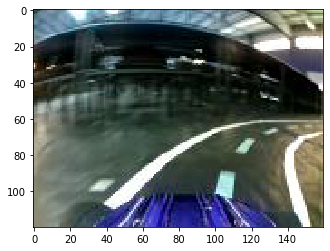

[1.4451014e-04 2.1938543e-04 9.9963605e-01]


In [9]:
out = model.predict(x_images, batch_size=200)

if out[1500,0] >= 0.5:
    print('left')
elif out[1500, 1] >= 0.5:
    print('straight')
elif out[1500, 2] >= 0.5:
    print('right')
    
plt.imshow(x_images[1500])
plt.show()
print(out[1500])